In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

(225, 225)


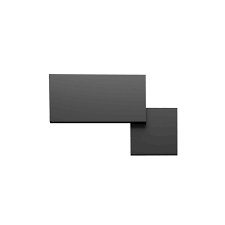

In [ ]:
# path = "/content/drive/MyDrive/Colab Notebooks/mona-finden-lovestory.jpg"
path = "/content/images.png"
scale = 1
img = cv2.imread(path)
img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
img = cv2.resize(src=img, dsize=((int)(img.shape[1] * scale), (int)(img.shape[1] * scale)))

print(img.shape)
cv2_imshow(img)

In [ ]:
class Hough:
    def __init__(self, img, num=180, ksize=5):
        h, w = img.shape
        self.img = img
        self.num = num
        
        self.tmin = -np.pi / 2
        self.dt = np.pi / num

        self.rmin = -np.sqrt(h**2 + w**2)
        self.dr = 2 * np.sqrt(h**2 + w**2) / num

        self.b = cv2.GaussianBlur(src=img, ksize=(ksize, ksize), sigmaX=1)
        self.c = cv2.Canny(self.b, 50, 150)
        self.a = np.zeros(shape=(num, num))
        self.nma = np.zeros(shape=(num, num))
        self.ma = np.zeros(shape=(num, num))

    def idx2t(self, i):
        return self.tmin + i * self.dt + self.dt / 2

    def t2idx(self, theta):
        return np.array(np.floor((theta - self.tmin) / self.dt), dtype=np.int32)

    def idx2r(self, j):
        return self.rmin + j * self.dr + self.dr / 2

    def r2idx(self, rho):
        return np.array(np.floor((rho - self.rmin) / self.dr), dtype=np.int32)

    def accumulate(self):
        a = np.zeros(shape=(self.num, self.num), dtype=np.uint32)
        w, h = self.c.shape
        for x in range(h):
            for y in range(w):
                if (self.c[x, y] != 0):    
                    aj = np.arange(self.num)
                    theta = self.idx2t(aj)
                    rho = x * np.cos(theta) + y * np.sin(theta)
                    ai = self.r2idx(rho)
                    a[ai, aj] += 1
        return a

    def nonmaxima_suppress(self):
        nma = np.array(object=self.a, dtype=np.uint32)
        h, w = self.a.shape
        for i in range(h):
            for j in range(w):
                try:
                    c1 = (nma[i, j] <= self.a[i - 1, j - 1]) or (nma[i, j] <= self.a[i - 1, j])
                    c2 = (nma[i, j] <= self.a[i - 1, j + 1]) or (nma[i, j] <= self.a[i, j - 1])
                    c3 = (nma[i, j] <= self.a[i, j + 1]) or (nma[i, j] <= self.a[i + 1, j - 1])
                    c4 = (nma[i, j] <= self.a[i + 1, j]) or (nma[i, j] <= self.a[i + 1, j + 1])
                    if (c1 or c2 or c3 or c4):
                        nma[i, j] = 0
                except IndexError as e:
                    pass 
        return nma

    def detect(self):
        self.a = self.accumulate()
        self.nma = self.nonmaxima_suppress()
        i, j = np.array(np.where(self.nma > 0))
        theta = self.idx2t(i)
        rho = self.idx2r(j)
        self.detected = np.array((theta, rho)).T
        return self.detected

    def lines(self, num=10, slope=100):
        i, j = np.array(np.where(self.nma > 0))
        theta = self.idx2t(i)
        rho = self.idx2r(j)
        value = self.nma[i, j]
        detected = np.array(object=(value, theta, rho)).T
        idx = detected[:,0].argsort()
        detected = detected[idx]

        lines = []

        for i in range(num):
            a = np.cos(detected[i, 1])
            b = np.sin(detected[i, 1])
            x0 = a * detected[i, 2]
            y0 = b * detected[i, 2]

            x1 = np.floor(x0 + slope * (-b))
            y1 = np.floor(y0 + slope * (a))
            x2 = np.floor(x0 - slope * (-b))
            y2 = np.floor(y0 - slope * (a))

            lines.append([x1, y1, x2, y2])

        return np.array(object=lines)

In [ ]:
h = Hough(img, 100)
h.detect()
l = h.lines(10,10)

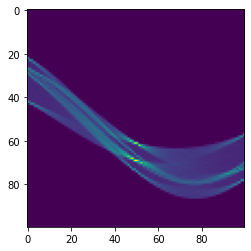

In [ ]:
plt.imshow(h.accumulate())

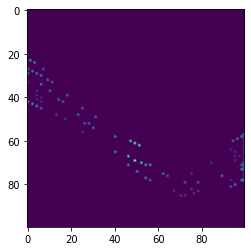

In [ ]:
plt.imshow(h.nonmaxima_suppress())

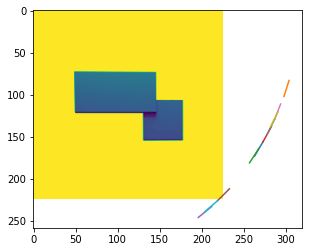

In [ ]:
plt.imshow(img)
for x1, y1, x2, y2 in l:
    plt.plot([x1, x2], [y1, y2])

plt.show()